# Overview on the spike mutations on the different lineages

In [175]:
import os
import re
import json
import glob
import time
from Bio.Alphabet import ProteinAlphabet
from logzero import logger
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from upsetplot import UpSet
import gtfparse

sns.set_style("whitegrid")
sns.set_context("notebook")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [174]:
pip freeze > constellation_analysis.requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Data loading

The lineages data comes from this repository https://github.com/cov-lineages/constellations

In [272]:
data_folder = "resources/constellations/constellations/definitions"
figures_folder = "figures/constellations"
gtf_file = "resources/Sars_cov_2.ASM985889v3.101.gtf"
dpi = 200

In [244]:
mutation_pattern = re.compile('([A-Z\-]+)([0-9]+)([A-Z\-]+)')

def parse_mutation(mutation, protein):
    reference = None
    position = None
    alternate = None
    if protein == "del":
        # del:28248:6
        values = mutation.split(":")
        if len(values) > 1:
            position = int(values[1])
    else:
        # S:R102I
        match = mutation_pattern.match(mutation.split(":")[1]) 
        if match:
            reference = match.group(1)
            position = int(match.group(2))
            alternate = match.group(3)
    return reference, position, alternate
    

lineages_tmp = {}
lineages_with_parent_tmp = []
p = re.compile('([A-Z\-]+)([0-9]+)([A-Z\-]+)')
for f in os.listdir(data_folder):
    if f.endswith(".json"):
        lineage = f.strip(".json")
        data = json.load(open(os.path.join(data_folder, f)))
        lineage = pd.DataFrame(data.get("sites"), columns=["sites"])
        lineage_name = data.get("variant").get("mrca_lineage")
        if lineage_name is None or lineage_name == 'None':
            lineage_name = data.get("variant").get("lineage_name")
        lineage["lineage"] = lineage_name
        parent_lineage = data.get("variant").get("parent_lineage")
        lineage["parent_lineage"] = parent_lineage
        lineage["protein"] = lineage.sites.transform(lambda l: l.split(":")[0])
        lineage["mutation"] = lineage.sites.transform(lambda l: str(l.split(":")[1]))
        lineage["position"] = lineage[["sites", "protein"]].apply(lambda m: parse_mutation(mutation=m[0], protein=m[1])[1], axis=1)
        lineage["reference"] = lineage[["sites", "protein"]].apply(lambda m: parse_mutation(mutation=m[0], protein=m[1])[0], axis=1)
        lineage["alternate"] = lineage[["sites", "protein"]].apply(lambda m: parse_mutation(mutation=m[0], protein=m[1])[2], axis=1)
        has_parent = parent_lineage is not None and parent_lineage != "None"
        if has_parent:
            lineages_with_parent_tmp.append(lineage)
        else:
            lineages_tmp[lineage_name] = lineage

# builds lineages having a parent... only one level inheritance is supported, AY.4.2 which has two levels is the only exception
for l in lineages_with_parent_tmp:
    lineage_name = l.lineage.head(1)[0]
    if lineage_name != "AY.4.2":
        parent_lineage_template = lineages_tmp.get(l.parent_lineage.head(1)[0]).copy(deep=True)
        parent_lineage_template.lineage = lineage_name
        joint_lineage = pd.concat([l, parent_lineage_template])
        lineages_tmp[lineage_name] = joint_lineage
    else:
        ay42_lineage = l

# builds inherited mutations into AY.4.2 only when AY.4 has already been built
parent_lineage_template = lineages_tmp.get("AY.4").copy(deep=True)
parent_lineage_template.lineage = "AY.4.2"
joint_lineage = pd.concat([ay42_lineage, parent_lineage_template])
lineages_tmp["AY.4.2"] = joint_lineage


lineages = pd.concat(lineages_tmp.values())
lineages.head()

,sites,lineage,parent_lineage,protein,mutation,position,reference,alternate
0,nsp3:L741F,A.23.1,None,nsp3,L741F,741.0,L,F
1,nsp6:M86I,A.23.1,None,nsp6,M86I,86.0,M,I
2,nsp6:L98F,A.23.1,None,nsp6,L98F,98.0,L,F
3,nsp6:M183I,A.23.1,None,nsp6,M183I,183.0,M,I
4,S:R102I,A.23.1,None,S,R102I,102.0,R,I


In [112]:
# all lineages
lineages.lineage.unique()

array(['A.23.1', 'B.1.617.3', 'C.37', 'B.1.1.318', 'B.1.621', 'B.1.526',
       'B.1.617.2', 'B.1.427', 'B.1.617.1', 'B.1.1.7', 'AV.1', 'B.1.525',
       'P.2', 'B.1.351', 'B.1.1.529', 'P.1', 'B.1.429', 'P.3', 'BA.1',
       'BA.3', 'BA.2', 'AY.4', 'AY.4.2'], dtype=object)

In [113]:
# lineages without a parent
lineages[lineages.parent_lineage.isna()].lineage.unique()

array(['A.23.1', 'B.1.617.3', 'C.37', 'B.1.1.318', 'B.1.621', 'B.1.526',
       'B.1.617.2', 'B.1.427', 'B.1.617.1', 'B.1.1.7', 'AV.1', 'B.1.525',
       'P.2', 'B.1.351', 'B.1.1.529', 'P.1', 'B.1.429', 'P.3', 'BA.1',
       'BA.3', 'BA.2', 'AY.4'], dtype=object)

In [114]:
# lineages with a parent
lineages[~lineages.parent_lineage.isna()].lineage.unique()

array(['BA.1', 'BA.3', 'BA.2', 'AY.4', 'AY.4.2'], dtype=object)

In [116]:
# lineages with sons (or daughters...)
lineages[~lineages.parent_lineage.isna()].parent_lineage.unique()

array(['B.1.1.529', 'B.1.617.2', 'AY.4'], dtype=object)

In [165]:
lineages.protein.unique()

array(['nsp3', 'nsp6', 'S', 'ORF8', 'N', 'nuc', 'nsp5', 'ORF7a', 'ORF1a',
       'ORF1b', 'nsp4', 'del', 'nsp15', 'M', 'spike', 'ORF3a', '1ab',
       'orf1a', 'orf1b', 'orf3a', 'n', 'nsp13', 's', '8', 'nsp12', 'E',
       'ORF1ab', 'NSP2', 'orf1ab', 'e', 'm', 'nsp7', 'orf6'], dtype=object)

In [191]:
gtf = gtfparse.parse_gtf(gtf_file)
gtf["gene_name"] = gtf.attribute.transform(lambda x: x.split("gene_name ")[1].strip("\"").split("\";")[0])
gtf.head()

,seqname,source,feature,start,end,score,strand,frame,attribute,gene_name
0,MN908947.3,ensembl,gene,266,21555,NaN,+,0,"gene_id ""ENSSASG00005000002""; gene_version ""1""...",ORF1ab
1,MN908947.3,ensembl,transcript,266,21555,NaN,+,0,"gene_id ""ENSSASG00005000002""; gene_version ""1""...",ORF1ab
2,MN908947.3,ensembl,exon,266,21555,NaN,+,0,"gene_id ""ENSSASG00005000002""; gene_version ""1""...",ORF1ab
3,MN908947.3,ensembl,CDS,266,21552,NaN,+,0,"gene_id ""ENSSASG00005000002""; gene_version ""1""...",ORF1ab
4,MN908947.3,ensembl,start_codon,266,268,NaN,+,0,"gene_id ""ENSSASG00005000002""; gene_version ""1""...",ORF1ab


In [193]:
gene_coordinates = gtf[gtf.feature == "gene"][["gene_name", "start", "end"]]
gene_coordinates

,gene_name,start,end
0,ORF1ab,266,21555
6,ORF1ab,266,13483
12,S,21563,25384
18,ORF3a,25393,26220
24,E,26245,26472
30,M,26523,27191
36,ORF6,27202,27387
42,ORF7a,27394,27759
48,ORF7b,27756,27887
54,ORF8,27894,28259


## Data normalization

### Protein names

There are some synonyms used for the proteins, eg: spike, S and s. These are normalised here.

Also, all the domains from protein ORF1ab are just considered as ORF1ab; and separate ORF1a and ORF1b are considered as ORF1ab.

### Mutation representation

Mutations are represented mostly in the protein space, but there are some exceptions that are represented in genomic coordinates. 
* Synonymous mutations are represented as nuc:A27259C and we are missing the corresponding protein annotation. In this example the mutations occurs in the ORF6 and its representation in the protein space would be R20R.
* Some deletions are represented as del:28362:9 and we are also missing the corresponding protein annotations.

We will manually annotate the overlapped proteins using a GTF reference file.

In [246]:
lineages[lineages.protein.isin(["del", "nuc"])]

,sites,lineage,parent_lineage,protein,mutation,position,reference,alternate
0,nuc:C835T,B.1.617.3,None,nuc,C835T,835.0,C,T
5,nuc:C16293T,B.1.617.3,None,nuc,C16293T,16293.0,C,T
11,nuc:T27384C,B.1.617.3,None,nuc,T27384C,27384.0,T,C
0,nuc:C3961T,B.1.1.318,None,nuc,C3961T,3961.0,C,T
5,del:11287:9,B.1.1.318,None,del,11287,11287.0,None,None
...,...,...,...,...,...,...,...,...
2,del:28248:6,AY.4.2,B.1.617.2,del,28248,28248.0,None,None
7,nuc:C8986T,AY.4.2,B.1.617.2,nuc,C8986T,8986.0,C,T
11,nuc:A11332G,AY.4.2,B.1.617.2,nuc,A11332G,11332.0,A,G
16,nuc:C27874T,AY.4.2,B.1.617.2,nuc,C27874T,27874.0,C,T


In [247]:
lineages.protein.unique()

array(['nsp3', 'nsp6', 'S', 'ORF8', 'N', 'nuc', 'nsp5', 'ORF7a', 'ORF1a',
       'ORF1b', 'nsp4', 'del', 'nsp15', 'M', 'spike', 'ORF3a', '1ab',
       'orf1a', 'orf1b', 'orf3a', 'n', 'nsp13', 's', '8', 'nsp12', 'E',
       'ORF1ab', 'NSP2', 'orf1ab', 'e', 'm', 'nsp7', 'orf6'], dtype=object)

In [248]:
def annotate_position(position):
    if position is None or position == np.nan:
        return None
    result = gene_coordinates[(gene_coordinates.start <= position) & (gene_coordinates.end > position)].gene_name
    if result.shape[0] == 0:
        return None
    return result.iloc[0]

In [260]:
protein_synonyms = {
    "S": ["S", "s", "spike"],
    "N": ["N", "n"],
    "M": ["M", "m"],
    "E": ["E", "e"],
    "ORF1ab": ["ORF1ab", "1ab", "orf1ab", "ORF1a", "ORF1b", "orf1a", "orf1b", "nsp3", "nsp6", "nsp5", "nsp4", "nsp15", "nsp13", "nsp7", "nsp12", "NSP2"],
    "ORF3a": ["ORF3a", "orf3a"],
    "ORF8": ["ORF8", "8"],
    "ORF6": ["ORF6", "orf6"]
}


def normalize_protein(protein):
    for canonical_name, synonyms in protein_synonyms.items():
        if protein in synonyms:
            return canonical_name
    return protein

lineages["protein_normalized"] = lineages[["protein", "position"]].apply(lambda x: normalize_protein(x[0]) if x[0] != "nuc" and x[0] != "del" else annotate_position(x[1]), axis=1)

lineages.reference.fillna("", inplace=True)
lineages.alternate.fillna("", inplace=True)

lineages["protein_normalized"].unique()

array(['ORF1ab', 'S', 'ORF8', 'N', 'ORF6', 'ORF7a', 'M', None, 'ORF3a',
       'E', 'ORF7b'], dtype=object)

In [261]:
lineages[lineages.protein == "del"].head(50)

,sites,lineage,parent_lineage,protein,mutation,position,reference,alternate,protein_normalized
5,del:11287:9,B.1.1.318,None,del,11287,11287.0,,,ORF1ab
8,del:21990:3,B.1.1.318,None,del,21990,21990.0,,,S
15,del:27887:15,B.1.1.318,None,del,27887,27887.0,,,None
18,del:28895:3,B.1.1.318,None,del,28895,28895.0,,,N
12,del:22280:9,B.1.351,None,del,22280,22280.0,,,S
13,del:11287:9,B.1.351,None,del,11287,11287.0,,,ORF1ab
34,del:28362:9,B.1.1.529,None,del,28362,28362.0,,,N
4,del:11287:9,P.1,None,del,11287,11287.0,,,ORF1ab
5,del:21980:9,P.3,None,del,21980,21980.0,,,S
2,del:6513:3,BA.1,B.1.1.529,del,6513,6513.0,,,ORF1ab


In [219]:
lineages[lineages.protein == "nuc"]["protein_normalized"] = lineages[lineages.protein == "nuc"].position.transform(annotate_position)
lineages[lineages.protein == "nuc"]

,sites,lineage,parent_lineage,protein,mutation,position,reference,alternate,protein_normalized,annotated_protein
0,nuc:C835T,B.1.617.3,None,nuc,C835T,835,C,T,nuc,ORF1ab
5,nuc:C16293T,B.1.617.3,None,nuc,C16293T,16293,C,T,nuc,ORF1ab
11,nuc:T27384C,B.1.617.3,None,nuc,T27384C,27384,T,C,nuc,ORF6
0,nuc:C3961T,B.1.1.318,None,nuc,C3961T,3961,C,T,nuc,ORF1ab
10,nuc:T23287C,B.1.1.318,None,nuc,T23287C,23287,T,C,nuc,S
...,...,...,...,...,...,...,...,...,...,...
0,nuc:T17040C,AY.4.2,AY.4,nuc,T17040C,17040,T,C,nuc,ORF1ab
7,nuc:C8986T,AY.4.2,B.1.617.2,nuc,C8986T,8986,C,T,nuc,ORF1ab
11,nuc:A11332G,AY.4.2,B.1.617.2,nuc,A11332G,11332,A,G,nuc,ORF1ab
16,nuc:C27874T,AY.4.2,B.1.617.2,nuc,C27874T,27874,C,T,nuc,ORF7b


In [256]:
for p in lineages.protein_normalized.unique():
    print(lineages[lineages.protein_normalized == p][["lineage", "protein_normalized", "mutation"]].groupby(["lineage", "protein_normalized"]).count())

                              mutation
lineage   protein_normalized          
A.23.1    ORF1ab                     4
AY.4      ORF1ab                    13
AY.4.2    ORF1ab                    14
B.1.1.318 ORF1ab                     7
B.1.1.529 ORF1ab                     6
B.1.1.7   ORF1ab                     9
B.1.351   ORF1ab                     4
B.1.427   ORF1ab                     4
B.1.429   ORF1ab                     4
B.1.525   ORF1ab                     7
B.1.526   ORF1ab                     7
B.1.617.1 ORF1ab                     5
B.1.617.3 ORF1ab                     6
B.1.621   ORF1ab                    12
BA.1      ORF1ab                    14
BA.2      ORF1ab                    22
BA.3      ORF1ab                    15
C.37      ORF1ab                     8
P.1       ORF1ab                     7
P.2       ORF1ab                     3
P.3       ORF1ab                     7
                              mutation
lineage   protein_normalized          
A.23.1    S              

In [257]:
lineages[["protein_normalized", "mutation"]].groupby("protein_normalized").count()

,mutation
protein_normalized,
E,6
M,21
N,52
ORF1ab,178
ORF3a,15
ORF6,6
ORF7a,8
ORF7b,6
ORF8,16


In [ ]:
lineages

## Aromatic and other large AAs

In [258]:
aromatic_aas = ["F", "W", "Y", "H"]
large_aas = ["I", "L", "M", "K", "R"]

In [262]:
lineages["removal_aromatic"] = lineages[["reference", "alternate"]].apply(lambda r: any([aa in r[0] for aa in aromatic_aas]) and all([not aa in r[1] for aa in aromatic_aas]), axis=1)
lineages["removal_large"] = lineages[["reference", "alternate"]].apply(lambda r: any([aa in r[0] for aa in large_aas]) and all([not aa in r[1] for aa in large_aas]), axis=1)
lineages["add_aromatic"] = lineages[["reference", "alternate"]].apply(lambda r: any([aa in r[1] for aa in aromatic_aas]) and all([not aa in r[0] for aa in aromatic_aas]), axis=1)
lineages["add_large"] = lineages[["reference", "alternate"]].apply(lambda r: any([aa in r[1] for aa in large_aas]) and all([not aa in r[0] for aa in large_aas]), axis=1)
lineages["count"] = True

In [263]:
lineages_mutation_types = lineages[(lineages.protein_normalized == "S")][["lineage", "count", "removal_aromatic", "add_aromatic", "removal_large", "add_large"]].groupby("lineage").sum().reset_index()
lineages_mutation_types

,lineage,count,removal_aromatic,add_aromatic,removal_large,add_large
0,A.23.1,6,1,2,0,3
1,AV.1,10,1,2,1,3
2,AY.4,7,0,0,0,3
3,AY.4.2,9,0,0,0,3
4,B.1.1.318,7,0,2,0,2
5,B.1.1.529,21,0,5,1,7
6,B.1.1.7,9,2,3,0,2
7,B.1.351,6,0,1,0,1
8,B.1.427,4,1,0,0,1
9,B.1.429,5,1,0,0,1


In [264]:
lineages_mutation_types["ratio_removal_aromatic"] = lineages_mutation_types["removal_aromatic"] / lineages_mutation_types["count"]
lineages_mutation_types["ratio_removal_large"] = lineages_mutation_types["removal_large"] / lineages_mutation_types["count"]
lineages_mutation_types["ratio_add_aromatic"] = lineages_mutation_types["add_aromatic"] / lineages_mutation_types["count"]
lineages_mutation_types["ratio_add_large"] = lineages_mutation_types["add_large"] / lineages_mutation_types["count"]
lineages_mutation_types

,lineage,count,removal_aromatic,add_aromatic,removal_large,add_large,ratio_removal_aromatic,ratio_removal_large,ratio_add_aromatic,ratio_add_large
0,A.23.1,6,1,2,0,3,0.166667,0.000000,0.333333,0.500000
1,AV.1,10,1,2,1,3,0.100000,0.100000,0.200000,0.300000
2,AY.4,7,0,0,0,3,0.000000,0.000000,0.000000,0.428571
3,AY.4.2,9,0,0,0,3,0.000000,0.000000,0.000000,0.333333
4,B.1.1.318,7,0,2,0,2,0.000000,0.000000,0.285714,0.285714
5,B.1.1.529,21,0,5,1,7,0.000000,0.047619,0.238095,0.333333
6,B.1.1.7,9,2,3,0,2,0.222222,0.000000,0.333333,0.222222
7,B.1.351,6,0,1,0,1,0.000000,0.000000,0.166667,0.166667
8,B.1.427,4,1,0,0,1,0.250000,0.000000,0.000000,0.250000
9,B.1.429,5,1,0,0,1,0.200000,0.000000,0.000000,0.200000


In [145]:
lineages[(lineages.protein_normalized == "S") & (lineages.lineage == "B.1.1.529")]

,sites,lineage,parent_lineage,protein,mutation,position,reference,alternate,protein_normalized,removal_aromatic,removal_large,add_aromatic,add_large,count
6,spike:G142D,B.1.1.529,None,spike,G142D,142,G,D,S,False,False,False,False,True
7,spike:G339D,B.1.1.529,None,spike,G339D,339,G,D,S,False,False,False,False,True
8,spike:S373P,B.1.1.529,None,spike,S373P,373,S,P,S,False,False,False,False,True
9,spike:S375F,B.1.1.529,None,spike,S375F,375,S,F,S,False,False,True,False,True
10,spike:K417N,B.1.1.529,None,spike,K417N,417,K,N,S,False,True,False,False,True
11,spike:N440K,B.1.1.529,None,spike,N440K,440,N,K,S,False,False,False,True,True
12,spike:S477N,B.1.1.529,None,spike,S477N,477,S,N,S,False,False,False,False,True
13,spike:T478K,B.1.1.529,None,spike,T478K,478,T,K,S,False,False,False,True,True
14,spike:E484A,B.1.1.529,None,spike,E484A,484,E,A,S,False,False,False,False,True
15,spike:Q493R,B.1.1.529,None,spike,Q493R,493,Q,R,S,False,False,False,True,True


In [149]:
pd.melt(lineages_mutation_types, id_vars = "lineage")

,lineage,variable,value
0,A.23.1,count,6
1,AV.1,count,10
2,AY.4,count,6
3,AY.4.2,count,8
4,B.1.1.318,count,4
...,...,...,...
110,BA.3,add_large,7
111,C.37,add_large,1
112,P.1,add_large,2
113,P.2,add_large,1


In [270]:
def plot_histogram(data, figname):
    fig = plt.figure(figsize=(30, 14))
    sns.barplot(data=data, x="lineage", y="value", hue="variable")
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.legend(title=None)
    sns.despine(bottom=True, left=True)
    fig.savefig(os.path.join(figures_folder, figname), dpi=dpi)

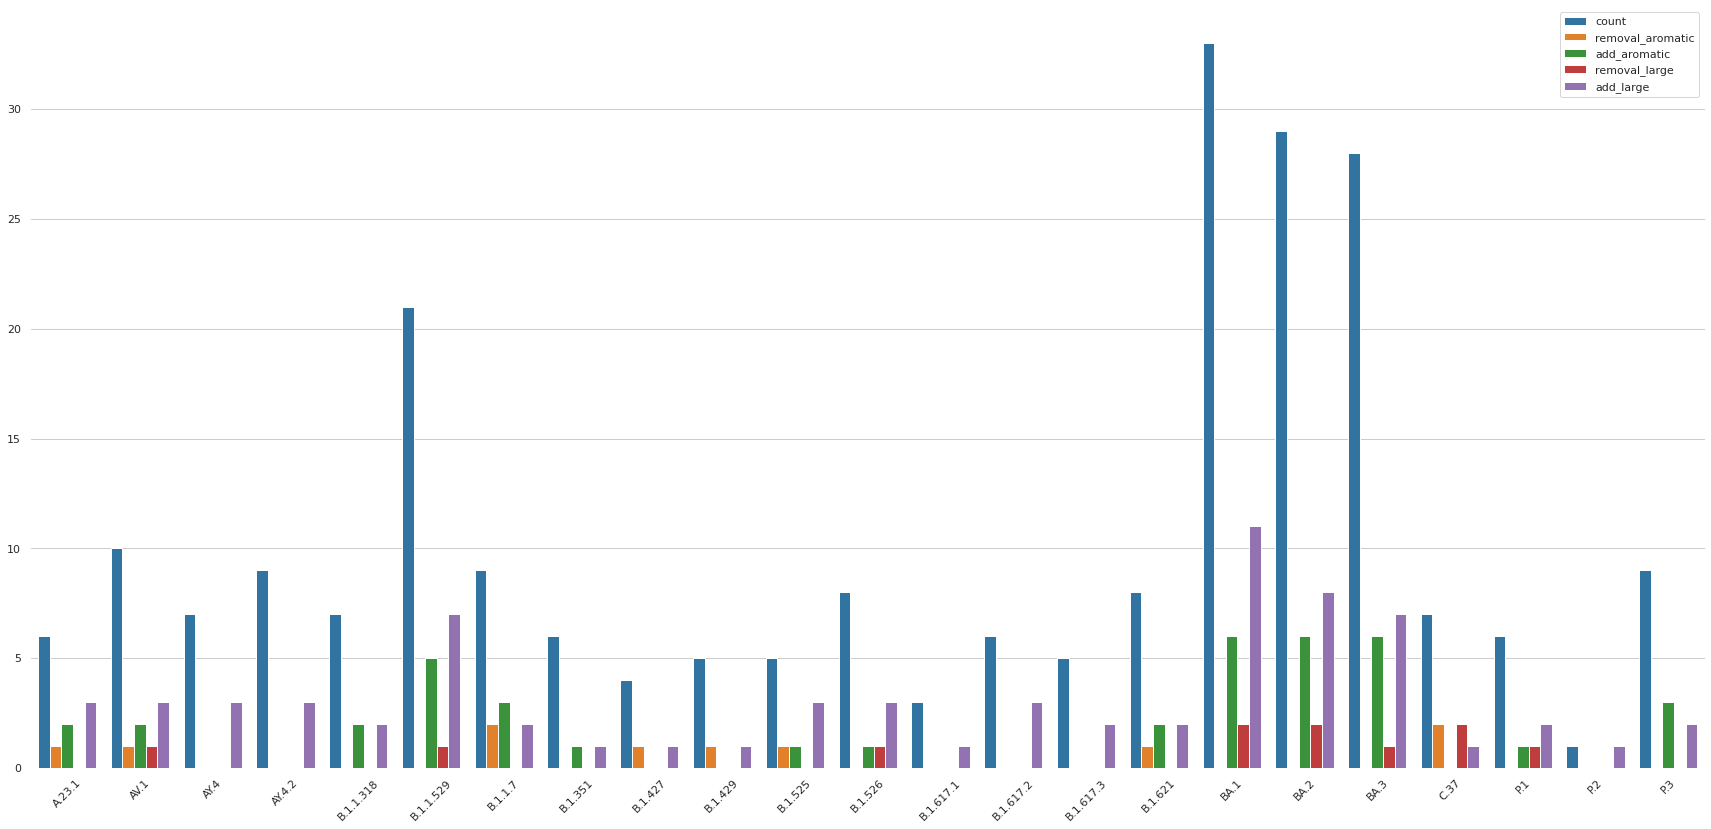

In [273]:
plot_histogram(
    data=pd.melt(lineages_mutation_types[["lineage", "count", "removal_aromatic", "add_aromatic", "removal_large", "add_large"]], id_vars = "lineage"),
    figname="figure_01_lineages_mutation_counts.png"
)

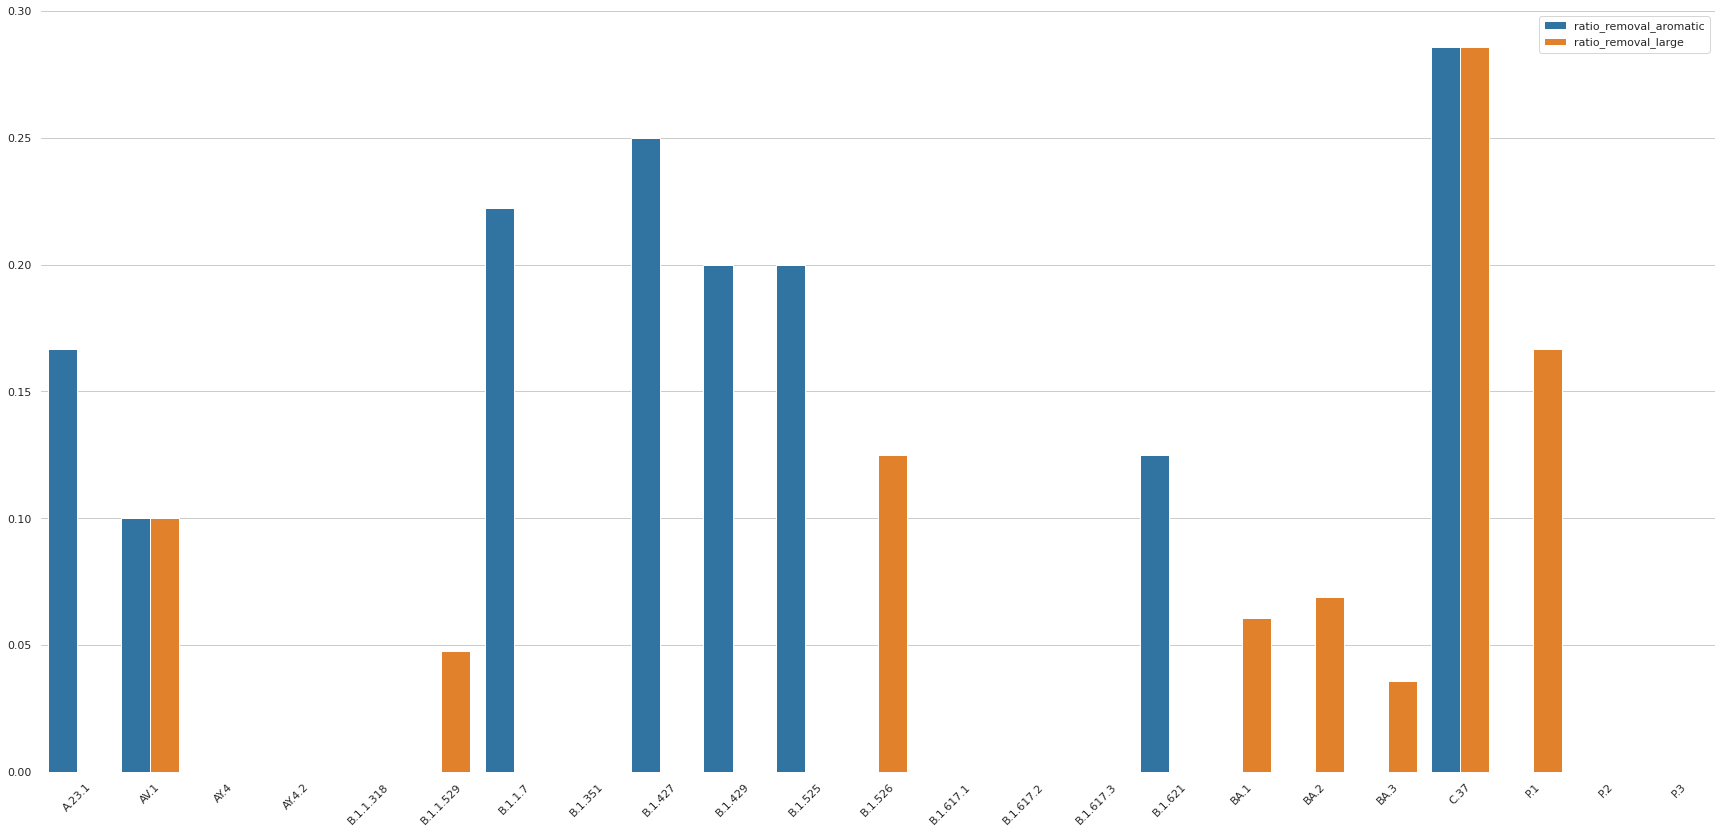

In [274]:
plot_histogram(
    data=pd.melt(lineages_mutation_types[["lineage", "ratio_removal_aromatic", "ratio_removal_large"]], id_vars = "lineage"),
    figname="figure_01_lineages_mutation_ratios_removaĺs.png"
)

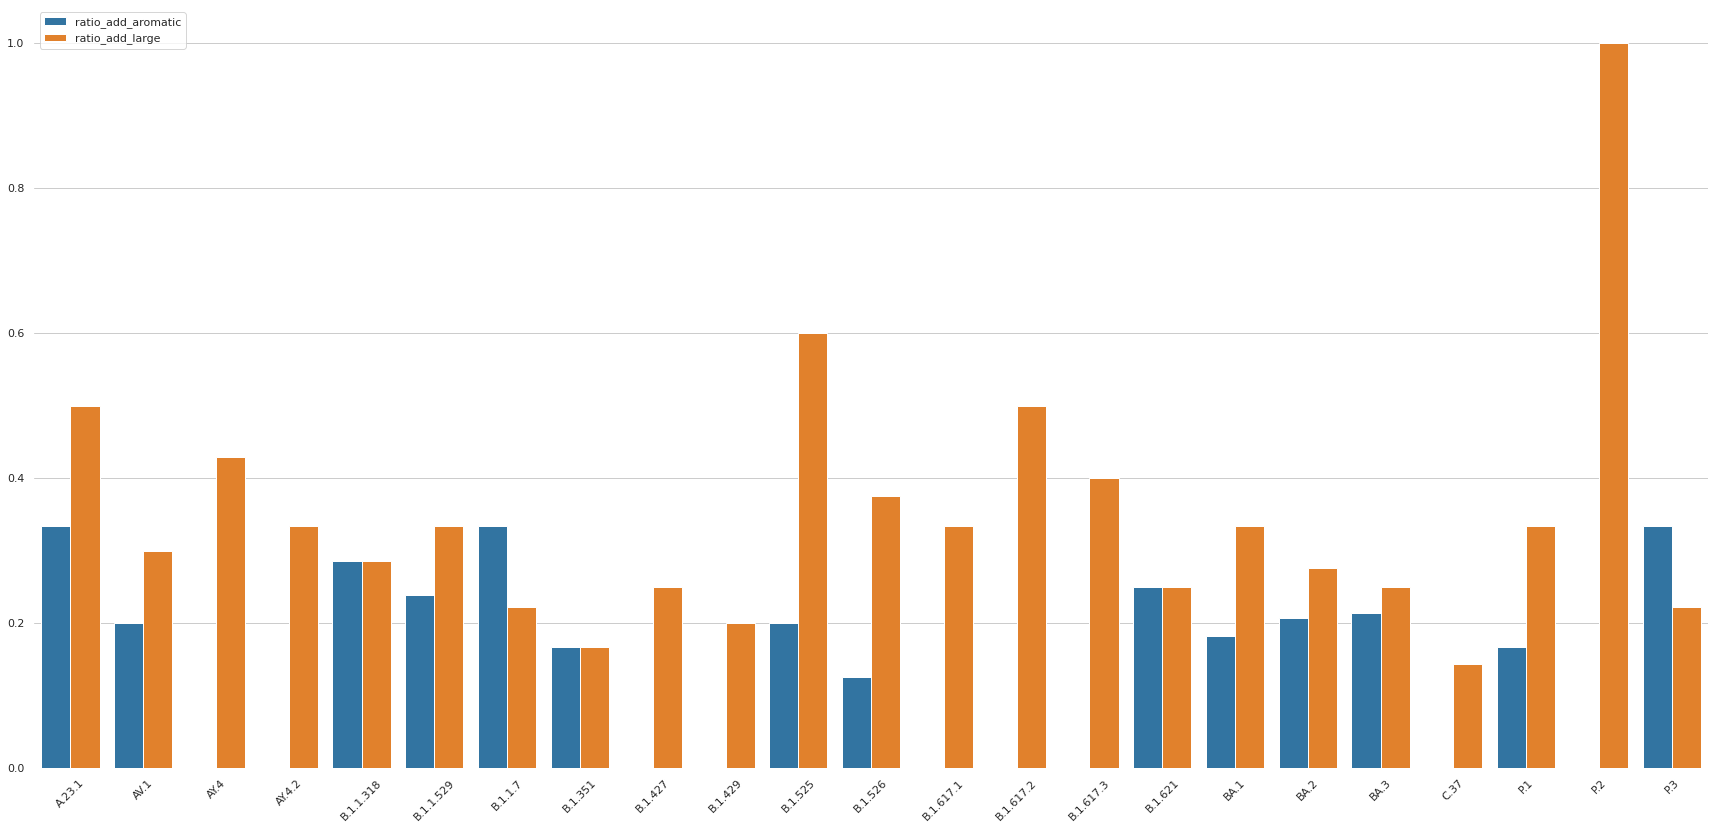

In [275]:
plot_histogram(
    data=pd.melt(lineages_mutation_types[["lineage", "ratio_add_aromatic", "ratio_add_large"]], id_vars = "lineage"),
    figname="figure_01_lineages_mutation_ratios_removaĺs.png"
)

## Building spike sequences for all lineages

In [277]:
lineages[(lineages.lineage == "B.1.1.529") & (lineages.protein_normalized == "S")]

,sites,lineage,parent_lineage,protein,mutation,position,reference,alternate,protein_normalized,removal_aromatic,removal_large,add_aromatic,add_large,count
6,spike:G142D,B.1.1.529,None,spike,G142D,142.0,G,D,S,False,False,False,False,True
7,spike:G339D,B.1.1.529,None,spike,G339D,339.0,G,D,S,False,False,False,False,True
8,spike:S373P,B.1.1.529,None,spike,S373P,373.0,S,P,S,False,False,False,False,True
9,spike:S375F,B.1.1.529,None,spike,S375F,375.0,S,F,S,False,False,True,False,True
10,spike:K417N,B.1.1.529,None,spike,K417N,417.0,K,N,S,False,True,False,False,True
11,spike:N440K,B.1.1.529,None,spike,N440K,440.0,N,K,S,False,False,False,True,True
12,spike:S477N,B.1.1.529,None,spike,S477N,477.0,S,N,S,False,False,False,False,True
13,spike:T478K,B.1.1.529,None,spike,T478K,478.0,T,K,S,False,False,False,True,True
14,spike:E484A,B.1.1.529,None,spike,E484A,484.0,E,A,S,False,False,False,False,True
15,spike:Q493R,B.1.1.529,None,spike,Q493R,493.0,Q,R,S,False,False,False,True,True


In [278]:
lineages[(lineages.lineage == "BA.1") & (lineages.protein_normalized == "S")]

,sites,lineage,parent_lineage,protein,mutation,position,reference,alternate,protein_normalized,removal_aromatic,removal_large,add_aromatic,add_large,count
8,spike:A67V,BA.1,B.1.1.529,spike,A67V,67.0,A,V,S,False,False,False,False,True
9,del:21765:6,BA.1,B.1.1.529,del,21765,21765.0,,,S,False,False,False,False,True
10,spike:T95I,BA.1,B.1.1.529,spike,T95I,95.0,T,I,S,False,False,False,True,True
11,del:21987:9,BA.1,B.1.1.529,del,21987,21987.0,,,S,False,False,False,False,True
12,del:22194:3,BA.1,B.1.1.529,del,22194,22194.0,,,S,False,False,False,False,True
14,spike:S371L,BA.1,B.1.1.529,spike,S371L,371.0,S,L,S,False,False,False,True,True
15,spike:G446S,BA.1,B.1.1.529,spike,G446S,446.0,G,S,S,False,False,False,False,True
16,spike:G496S,BA.1,B.1.1.529,spike,G496S,496.0,G,S,S,False,False,False,False,True
17,spike:T547K,BA.1,B.1.1.529,spike,T547K,547.0,T,K,S,False,False,False,True,True
18,spike:N856K,BA.1,B.1.1.529,spike,N856K,856.0,N,K,S,False,False,False,True,True
